<h1 style="font-size:30px;">Semantic Segmentation using DeepLabv3+ (KITTI Road Dataset)</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob as glob
import albumentations as A
import requests
import zipfile
import time 
import pathlib

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     Conv2DTranspose, BatchNormalization, Activation,
                                     Dropout, UpSampling2D, Concatenate)
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 2
    IMG_WIDTH:   int = 224
    IMG_HEIGHT:  int = 224
    DATA_TRAIN_IMAGES: str = 'dataset_kitti_road_segmentation/train/images/*.png'
    DATA_TRAIN_LABELS: str = 'dataset_kitti_road_segmentation/train/masks/*.png'
    DATA_VALID_IMAGES: str = 'dataset_kitti_road_segmentation/valid/images/*.png'
    DATA_VALID_LABELS: str = 'dataset_kitti_road_segmentation/valid/masks/*.png'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 8
    EPOCHS:          int = 51
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR:  str = 'model_checkpoint/DeepLabV3_Road'
        
@dataclass(frozen=True)
class InferenceConfig:
    NUM_BATCHES:     int = 3

### convolution_block

In [4]:
def convolution_block(block_input,
                      num_filters=256,
                      kernel_size=3,
                      dilation_rate=1,
                      padding="same",
                      use_bias=False):
    
    x = Conv2D(num_filters, kernel_size=kernel_size, 
               dilation_rate=dilation_rate, padding="same", use_bias=use_bias)(block_input)

    x = BatchNormalization()(x)

    return Activation('relu')(x)

### DilatedSpatialPyramidPooling

In [5]:
def DilatedSpatialPyramidPooling(dspp_input):
    
    dims = dspp_input.shape
    
    # Create a 1x1 feature map using AveragePooling2D.
    x = AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    
    # Upsample the feature map to the original size.
    out_pool = UpSampling2D(size=(dims[1], dims[2]), interpolation="bilinear")(x)

    # Create feature maps of the same shape with different dilation rates.
    out_1  = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6  = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    # Combine all the feature maps and process them through a 1x1 convolutional block.
    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    
    return output

### deeplabv3plus

In [6]:
def deeplabv3plus(num_classes, shape):
    
    model_input = Input(shape=shape)
    preprocessing = preprocess_input(model_input)
    backbone = ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessing)

    # Set all layers in the backbone as trainable.
    for layer in backbone.layers:
        layer.trainable = True
        
    # Obtain a (lower resolution) feature map from the backbone.
    # Shape: (14, 14, 256)
    input_a = backbone.get_layer("conv4_block6_2_relu").output
    
    # Pass through Atrous Spatial Pyramid Pooling to obtain features at various scales.
    input_a = DilatedSpatialPyramidPooling(input_a)
    
    # Upsample the concatenated features.
    input_a = UpSampling2D(size=(4, 4), interpolation="bilinear")(input_a)
    
    # Obtain a second (higher resolution) feature map from the backbone and apply convolution.
    # Shape: (56, 56, 64)
    input_b = backbone.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=256, kernel_size=1)

    # Concatenate both sets of feature maps and perform final decoder processing.
    x = Concatenate(axis=-1)([input_a, input_b])
    
    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    
    # Apply 1x1 convolution to limit the depth of the feature maps to the number of classes.
    outputs = Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    
    model_output = Activation('softmax')(outputs)
    
    model = Model(inputs=model_input, outputs=model_output)
    
    return model

In [7]:
model = deeplabv3plus(num_classes=DatasetConfig.NUM_CLASSES, 
                      shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

In [8]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [9]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [10]:
save_name = "dataset_kitti_road_segmentation.zip"

if not os.path.exists(save_name):
    download_file(
        "https://www.dropbox.com/s/6vpsgn4gqtdiu01/dataset_kitti_road_segmentation.zip?dl=1",
        save_name
    )

    unzip(zip_file=save_name)

In [11]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(Sequence):
    
    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug):
        
        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug
        
        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")
        
        if self.aug:
            self.train_transforms = self.transforms()
        
        self.resize_transforms = self.resize()
        
    def __len__(self):
        
        return len(self.mask_paths) // self.batch_size

    def transforms(self):
        
        # Data augmentation.
        train_transforms = A.Compose([A.HorizontalFlip(p=0.33),])
        return train_transforms
    
    def resize(self):
        
        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms
    
    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]
        
        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
     
            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']
            
            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img # Image Normalization not done because the pretrained ResNet model 
                            # requires it's own preprocess_input function.
            
            msk = rgb_to_onehot(msk)
            
            self.y[j] = msk.argmax(-1)
            
        return self.x, self.y

In [12]:
id2color = {
    0: (255, 0, 0),   # Background: red
    1: (255, 0, 255), # Road: pink
}

id2color_display = {
    0: (0, 0, 0),     # Background: black
    1: (0, 255, 0),   # Road: green
}

In [13]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):
    
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )
    
    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])
        
    return arr

In [14]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):
    
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))
    
    for k in color_map.keys():
        output[single_layer==k] = color_map[k]
        
    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

In [15]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):
    
    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.
    
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return np.clip(image, 0.0, 1.0)

In [16]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):
    
    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]
    
    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    
    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)
    
    data_list.append(overlayed_image)
    
    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')
        
    plt.show()

In [17]:
def create_datasets(aug=False):
    
    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))
    
    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                  )
    
    return train_ds, valid_ds

In [18]:
train_ds, valid_ds = create_datasets(aug=True)

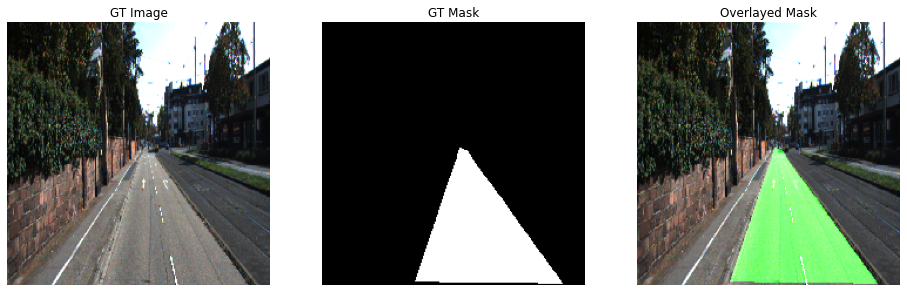

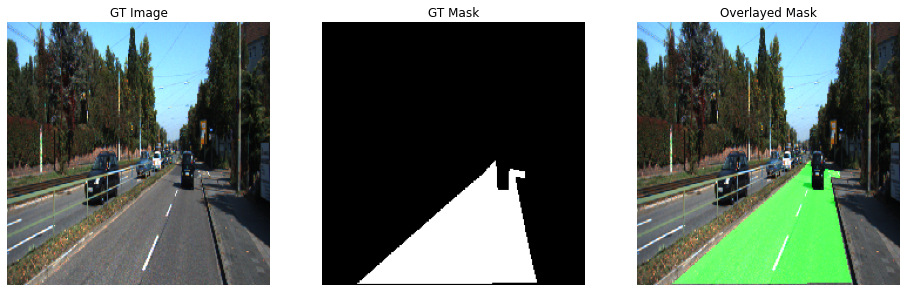

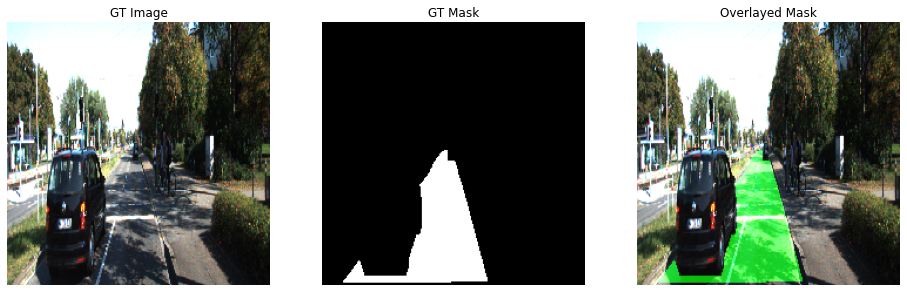

In [19]:
for i, (images, masks) in enumerate(train_ds):
    if i == 3:
        break
    image, mask = images[0], masks[0]
    display_image_and_mask([image/255.0, mask], # Image and Mask in same pixel value range [0.0, 1.0] for display.
                           color_mask=False, 
                           color_map=id2color_display)

### Mean IoU Metric

In [20]:
def mean_iou(y_true, y_pred):
    
    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    # Convert single channel (sparse) ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Convert multi-channel predicted output to one-hot encoded thresholded output for metric computation. 
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Union: Shape: (batch_size, num_classes)
    union = total - intersection

    # Boolean (then converted to float) value for each class if it is present or not. 
    # Shape: (batch_size, num_classes)
    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)

    # Sum along axis(1) to get number of classes in each image.
    # Shape: (batch_size,)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    # Here, we use tf.math.divide_no_nan() to prevent division by 0 (i.e., 0/0 = 0).
    # Shape: (batch_size, num_classes)
    iou = tf.math.divide_no_nan(intersection, union)

    # IoU per image. Average over the total number of classes present in y_true and y_pred.
    # Shape: (batch_size,)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present
    
    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)
    
    return mean_iou

In [21]:
model.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE),   
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', mean_iou],
             )

In [ ]:
# Create a new checkpoint directory every time.
if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
    os.makedirs(TrainingConfig.CHECKPOINT_DIR)
    
num_versions = len(os.listdir(TrainingConfig.CHECKPOINT_DIR)) + 1
version_dir = TrainingConfig.CHECKPOINT_DIR +'/version_roadseg_' + str(num_versions)
os.makedirs(version_dir)

# Callback to save the best model based on validation loss.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=version_dir,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='auto',
                                                               save_best_only=True,
                                                              )

In [ ]:
history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS, 
                    verbose=1,
                    validation_data=valid_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[model_checkpoint_callback],
                   )

Epoch 1/51
30/30 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8643 - mean_iou: 0.7415

30/30 [==============================] - 57s 1s/step - loss: 0.3148 - accuracy: 0.8643 - mean_iou: 0.7415 - val_loss: 0.4969 - val_accuracy: 0.8865 - val_mean_iou: 0.7369
Epoch 2/51
30/30 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9701 - mean_iou: 0.9030

30/30 [==============================] - 31s 1s/step - loss: 0.0840 - accuracy: 0.9701 - mean_iou: 0.9030 - val_loss: 0.3523 - val_accuracy: 0.9392 - val_mean_iou: 0.8362
Epoch 3/51
30/30 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9787 - mean_iou: 0.9296

30/30 [==============================] - 32s 1s/step - loss: 0.0615 - accuracy: 0.9787 - mean_iou: 0.9296 - val_loss: 0.2923 - val_accuracy: 0.9513 - val_mean_iou: 0.8678
Epoch 4/51
30/30 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9835 - mean_iou: 0.9434

30/30 [==============================] - 31s 1s/step - loss: 0.0471 - accuracy: 0.9835 - mean_iou: 0.9434 - val_loss: 0.2647 - val_accuracy: 0.9607 - val_mean_iou: 0.8940
Epoch 5/51
30/30 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9850 - mean_iou: 0.9497

30/30 [==============================] - 31s 1s/step - loss: 0.0413 - accuracy: 0.9850 - mean_iou: 0.9497 - val_loss: 0.1511 - val_accuracy: 0.9684 - val_mean_iou: 0.9070
Epoch 6/51
30/30 [==============================] - 10s 291ms/step - loss: 0.0345 - accuracy: 0.9877 - mean_iou: 0.9574 - val_loss: 0.3193 - val_accuracy: 0.9612 - val_mean_iou: 0.8952
Epoch 7/51
30/30 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9886 - mean_iou: 0.9607

30/30 [==============================] - 32s 1s/step - loss: 0.0308 - accuracy: 0.9886 - mean_iou: 0.9607 - val_loss: 0.1127 - val_accuracy: 0.9695 - val_mean_iou: 0.9109
Epoch 8/51
30/30 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9898 - mean_iou: 0.9646

30/30 [==============================] - 32s 1s/step - loss: 0.0274 - accuracy: 0.9898 - mean_iou: 0.9646 - val_loss: 0.0772 - val_accuracy: 0.9748 - val_mean_iou: 0.9228
Epoch 9/51
30/30 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9908 - mean_iou: 0.9677

30/30 [==============================] - 32s 1s/step - loss: 0.0251 - accuracy: 0.9908 - mean_iou: 0.9677 - val_loss: 0.0588 - val_accuracy: 0.9804 - val_mean_iou: 0.9376
Epoch 10/51
30/30 [==============================] - 10s 306ms/step - loss: 0.0233 - accuracy: 0.9915 - mean_iou: 0.9703 - val_loss: 0.0626 - val_accuracy: 0.9763 - val_mean_iou: 0.9266
Epoch 11/51
30/30 [==============================] - 10s 308ms/step - loss: 0.0223 - accuracy: 0.9918 - mean_iou: 0.9714 - val_loss: 0.0591 - val_accuracy: 0.9784 - val_mean_iou: 0.9325
Epoch 12/51
30/30 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9923 - mean_iou: 0.9731

30/30 [==============================] - 32s 1s/step - loss: 0.0208 - accuracy: 0.9923 - mean_iou: 0.9731 - val_loss: 0.0543 - val_accuracy: 0.9800 - val_mean_iou: 0.9372
Epoch 13/51
30/30 [==============================] - 10s 297ms/step - loss: 0.0201 - accuracy: 0.9926 - mean_iou: 0.9740 - val_loss: 0.0594 - val_accuracy: 0.9779 - val_mean_iou: 0.9303
Epoch 14/51
30/30 [==============================] - 10s 311ms/step - loss: 0.0196 - accuracy: 0.9928 - mean_iou: 0.9749 - val_loss: 0.0593 - val_accuracy: 0.9781 - val_mean_iou: 0.9313
Epoch 15/51
30/30 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9927 - mean_iou: 0.9741

30/30 [==============================] - 32s 1s/step - loss: 0.0202 - accuracy: 0.9927 - mean_iou: 0.9741 - val_loss: 0.0537 - val_accuracy: 0.9807 - val_mean_iou: 0.9391
Epoch 16/51
30/30 [==============================] - 10s 313ms/step - loss: 0.0180 - accuracy: 0.9934 - mean_iou: 0.9766 - val_loss: 0.0551 - val_accuracy: 0.9807 - val_mean_iou: 0.9394
Epoch 17/51
30/30 [==============================] - 10s 298ms/step - loss: 0.0174 - accuracy: 0.9936 - mean_iou: 0.9775 - val_loss: 0.0561 - val_accuracy: 0.9812 - val_mean_iou: 0.9411
Epoch 18/51
30/30 [==============================] - 10s 297ms/step - loss: 0.0177 - accuracy: 0.9938 - mean_iou: 0.9781 - val_loss: 0.0542 - val_accuracy: 0.9817 - val_mean_iou: 0.9419
Epoch 19/51
30/30 [==============================] - 10s 309ms/step - loss: 0.0162 - accuracy: 0.9942 - mean_iou: 0.9795 - val_loss: 0.0551 - val_accuracy: 0.9815 - val_mean_iou: 0.9418
Epoch 20/51
30/30 [==============================] - 10s 307ms/step - loss: 0.0153 - 

30/30 [==============================] - 31s 1s/step - loss: 0.0147 - accuracy: 0.9945 - mean_iou: 0.9806 - val_loss: 0.0510 - val_accuracy: 0.9822 - val_mean_iou: 0.9434
Epoch 22/51
30/30 [==============================] - 10s 299ms/step - loss: 0.0141 - accuracy: 0.9948 - mean_iou: 0.9816 - val_loss: 0.0560 - val_accuracy: 0.9815 - val_mean_iou: 0.9419
Epoch 23/51
30/30 [==============================] - 10s 311ms/step - loss: 0.0135 - accuracy: 0.9950 - mean_iou: 0.9821 - val_loss: 0.0524 - val_accuracy: 0.9821 - val_mean_iou: 0.9431
Epoch 24/51
30/30 [==============================] - 13s 395ms/step - loss: 0.0131 - accuracy: 0.9951 - mean_iou: 0.9825 - val_loss: 0.0556 - val_accuracy: 0.9821 - val_mean_iou: 0.9432
Epoch 25/51
30/30 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9949 - mean_iou: 0.9816

30/30 [==============================] - 32s 1s/step - loss: 0.0135 - accuracy: 0.9949 - mean_iou: 0.9816 - val_loss: 0.0508 - val_accuracy: 0.9822 - val_mean_iou: 0.9436
Epoch 26/51
30/30 [==============================] - 10s 313ms/step - loss: 0.0138 - accuracy: 0.9948 - mean_iou: 0.9814 - val_loss: 0.0555 - val_accuracy: 0.9815 - val_mean_iou: 0.9416
Epoch 27/51
30/30 [==============================] - 10s 295ms/step - loss: 0.0130 - accuracy: 0.9950 - mean_iou: 0.9821 - val_loss: 0.0556 - val_accuracy: 0.9814 - val_mean_iou: 0.9413
Epoch 28/51
30/30 [==============================] - 10s 300ms/step - loss: 0.0132 - accuracy: 0.9949 - mean_iou: 0.9817 - val_loss: 0.0568 - val_accuracy: 0.9816 - val_mean_iou: 0.9419
Epoch 29/51
30/30 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9949 - mean_iou: 0.9819

30/30 [==============================] - 31s 1s/step - loss: 0.0131 - accuracy: 0.9949 - mean_iou: 0.9819 - val_loss: 0.0507 - val_accuracy: 0.9828 - val_mean_iou: 0.9447
Epoch 30/51
30/30 [==============================] - 11s 320ms/step - loss: 0.0130 - accuracy: 0.9950 - mean_iou: 0.9822 - val_loss: 0.0563 - val_accuracy: 0.9817 - val_mean_iou: 0.9424
Epoch 31/51
30/30 [==============================] - 10s 309ms/step - loss: 0.0126 - accuracy: 0.9952 - mean_iou: 0.9827 - val_loss: 0.0523 - val_accuracy: 0.9826 - val_mean_iou: 0.9445
Epoch 32/51
30/30 [==============================] - 10s 294ms/step - loss: 0.0122 - accuracy: 0.9952 - mean_iou: 0.9830 - val_loss: 0.0519 - val_accuracy: 0.9824 - val_mean_iou: 0.9442
Epoch 33/51
30/30 [==============================] - 10s 298ms/step - loss: 0.0116 - accuracy: 0.9955 - mean_iou: 0.9840 - val_loss: 0.0532 - val_accuracy: 0.9828 - val_mean_iou: 0.9450
Epoch 34/51
30/30 [==============================] - 13s 397ms/step - loss: 0.0119 - 

30/30 [==============================] - 34s 1s/step - loss: 0.0113 - accuracy: 0.9956 - mean_iou: 0.9840 - val_loss: 0.0506 - val_accuracy: 0.9831 - val_mean_iou: 0.9459
Epoch 37/51
30/30 [==============================] - 10s 296ms/step - loss: 0.0104 - accuracy: 0.9959 - mean_iou: 0.9854 - val_loss: 0.0535 - val_accuracy: 0.9825 - val_mean_iou: 0.9444
Epoch 38/51
30/30 [==============================] - 13s 397ms/step - loss: 0.0103 - accuracy: 0.9960 - mean_iou: 0.9856 - val_loss: 0.0538 - val_accuracy: 0.9826 - val_mean_iou: 0.9451
Epoch 39/51
30/30 [==============================] - 13s 398ms/step - loss: 0.0102 - accuracy: 0.9960 - mean_iou: 0.9858 - val_loss: 0.0560 - val_accuracy: 0.9821 - val_mean_iou: 0.9434
Epoch 40/51
30/30 [==============================] - 10s 298ms/step - loss: 0.0106 - accuracy: 0.9959 - mean_iou: 0.9851 - val_loss: 0.0533 - val_accuracy: 0.9827 - val_mean_iou: 0.9457
Epoch 41/51
30/30 [==============================] - 10s 311ms/step - loss: 0.0102 - 

30/30 [==============================] - 32s 1s/step - loss: 0.0100 - accuracy: 0.9960 - mean_iou: 0.9859 - val_loss: 0.0503 - val_accuracy: 0.9834 - val_mean_iou: 0.9471
Epoch 46/51
30/30 [==============================] - 10s 294ms/step - loss: 0.0095 - accuracy: 0.9963 - mean_iou: 0.9866 - val_loss: 0.0539 - val_accuracy: 0.9830 - val_mean_iou: 0.9461
Epoch 47/51
30/30 [==============================] - 10s 300ms/step - loss: 0.0103 - accuracy: 0.9959 - mean_iou: 0.9853 - val_loss: 0.0516 - val_accuracy: 0.9835 - val_mean_iou: 0.9472
Epoch 48/51
30/30 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9963 - mean_iou: 0.9867

30/30 [==============================] - 32s 1s/step - loss: 0.0094 - accuracy: 0.9963 - mean_iou: 0.9867 - val_loss: 0.0501 - val_accuracy: 0.9839 - val_mean_iou: 0.9490
Epoch 49/51
30/30 [==============================] - 10s 311ms/step - loss: 0.0091 - accuracy: 0.9964 - mean_iou: 0.9870 - val_loss: 0.0550 - val_accuracy: 0.9833 - val_mean_iou: 0.9471
Epoch 50/51
30/30 [==============================] - 10s 300ms/step - loss: 0.0089 - accuracy: 0.9965 - mean_iou: 0.9873 - val_loss: 0.0540 - val_accuracy: 0.9832 - val_mean_iou: 0.9467
Epoch 51/51
30/30 [==============================] - 13s 394ms/step - loss: 0.0087 - accuracy: 0.9966 - mean_iou: 0.9877 - val_loss: 0.0535 - val_accuracy: 0.9834 - val_mean_iou: 0.9476


In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

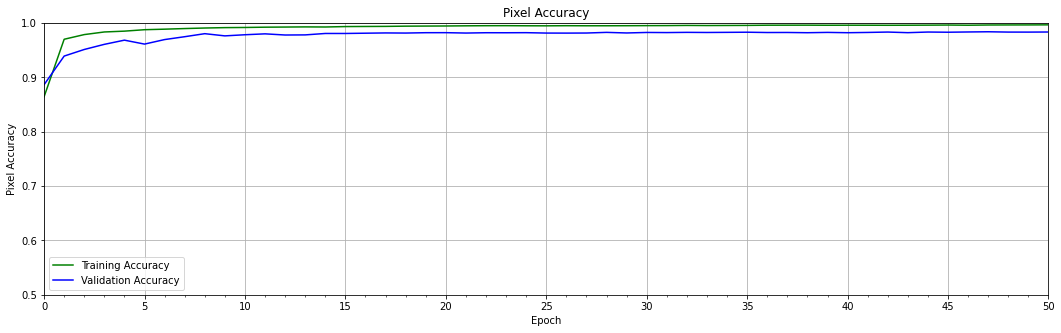

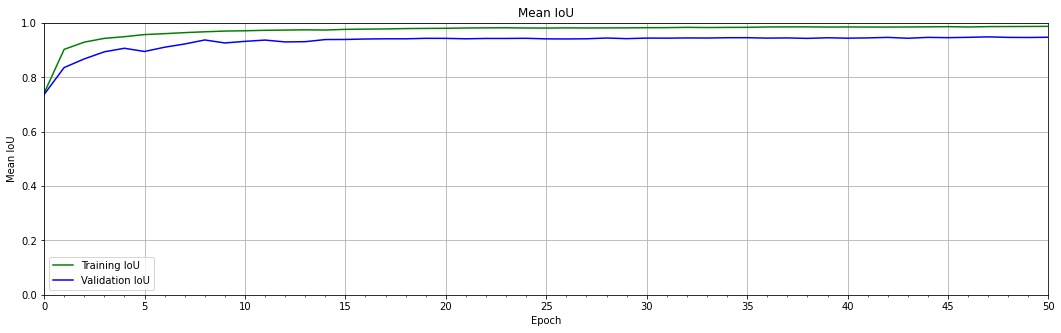

In [ ]:
# Pixel accuracy.
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# Mean IoU.
train_iou = history.history["mean_iou"]
valid_iou = history.history["val_mean_iou"]

plot_results([ train_acc, valid_acc ], 
            ylabel="Pixel Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_iou, valid_iou ], 
            ylabel="Mean IoU",
            ylim = [0.0, 1.0],
            metric_name=["Training IoU", "Validation IoU"],
            color=["g", "b"])

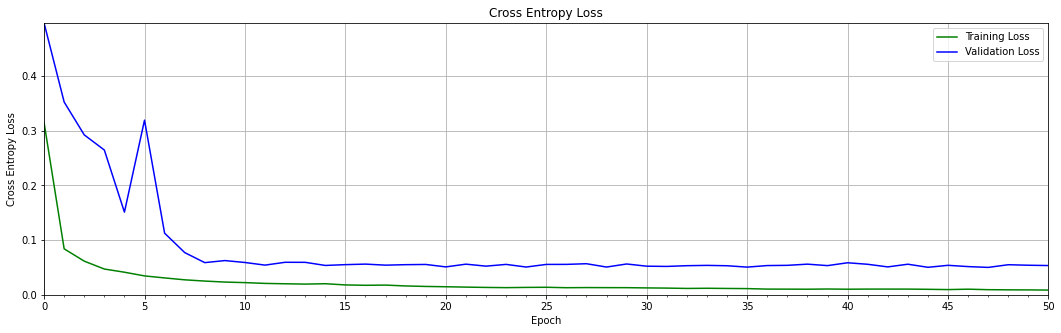

In [ ]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],        
            ylabel="Cross Entropy Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [ ]:
trained_model = tf.keras.models.load_model(version_dir, 
                                           custom_objects={'mean_iou':mean_iou})

In [ ]:
evaluate = trained_model.evaluate(valid_ds)

print(f"Model evaluation accuracy: {evaluate[1]*100.:.3f}")
print(f"Model evaluation mean IoU: {evaluate[2]*100.:.3f}")

5/5 [==============================] - 2s 179ms/step - loss: 0.0501 - accuracy: 0.9839 - mean_iou: 0.9490
Model evaluation accuracy: 98.388
Model evaluation mean IoU: 94.896


In [ ]:
def inference(model, dataset):

    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, data in enumerate(dataset):
        
        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype('float32')
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img).astype('uint8')
        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):
            
            fig = plt.figure(figsize=(20,8))
            
            # Display the original image.
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text('Actual frame')
            plt.axis('off')
            
            # Display the ground truth mask.
            true_mask = batch_mask[i]
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_title('Ground truth labels')
            ax2.imshow(true_mask)
            plt.axis('off')
            
            # Display the predicted segmentation mask. 
            pred_mask = pred_all[i]
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_title('Predicted labels')
            ax3.imshow(pred_mask)
            plt.axis('off')

            # Display the predicted segmentation mask overlayed on the original image.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color_display)
            overlayed_image = image_overlay((batch_img[i]), np.array(pred_mask_rgb.astype('uint8')))
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_title('Overlayed image')
            ax4.imshow(overlayed_image)
            plt.axis('off')
            
            plt.show()

1/1 [==============================] - 1s 946ms/step


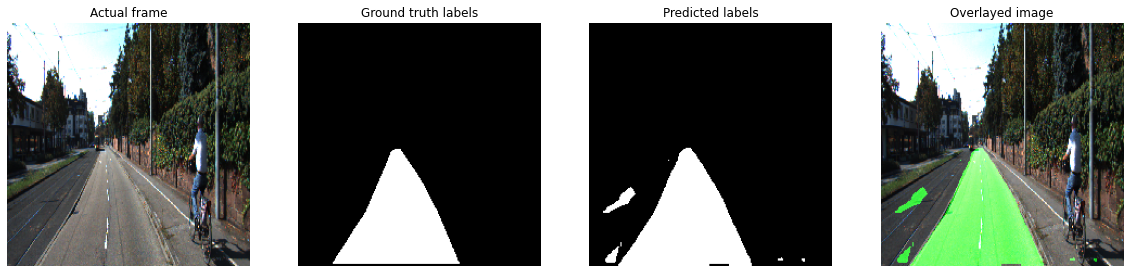

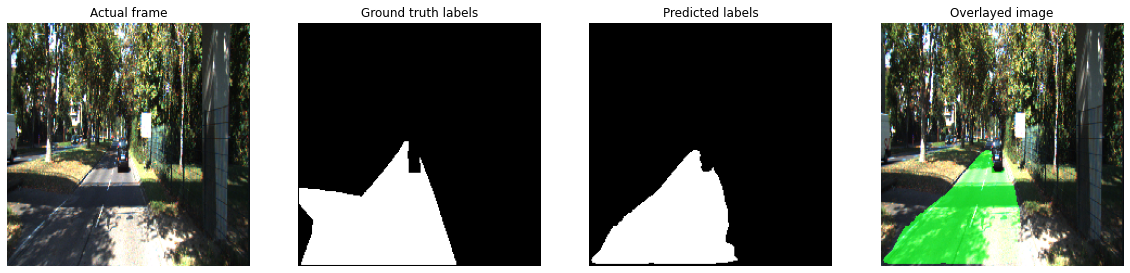

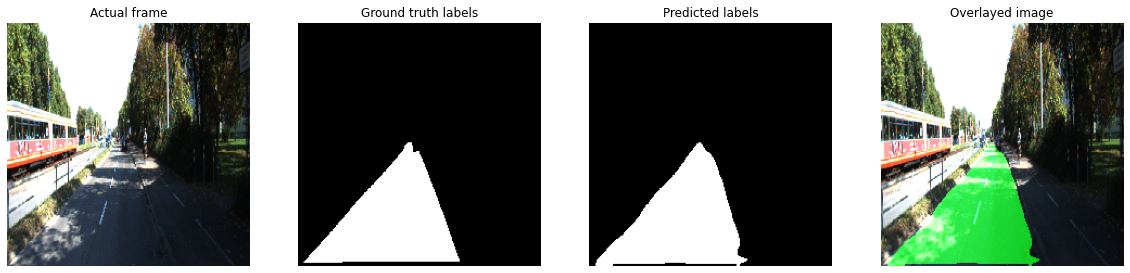

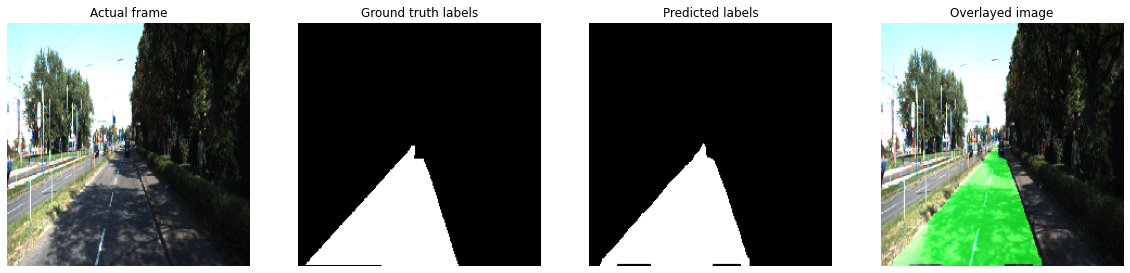

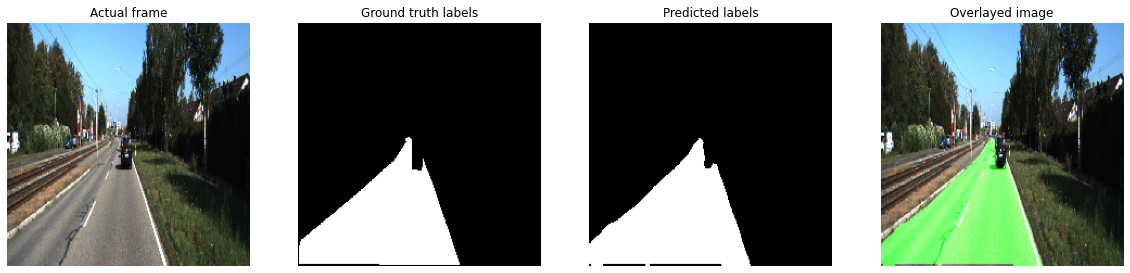

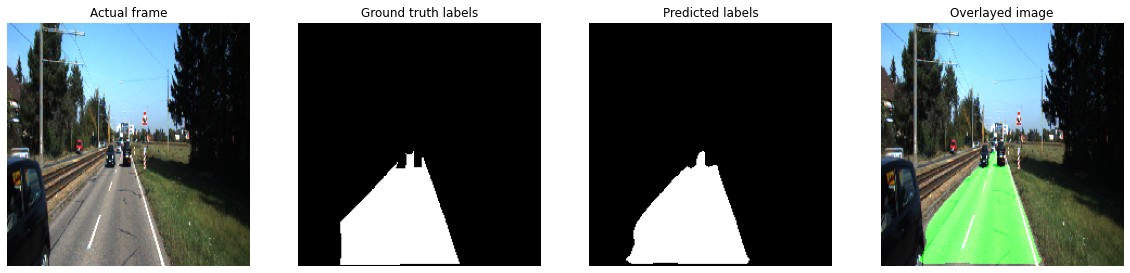

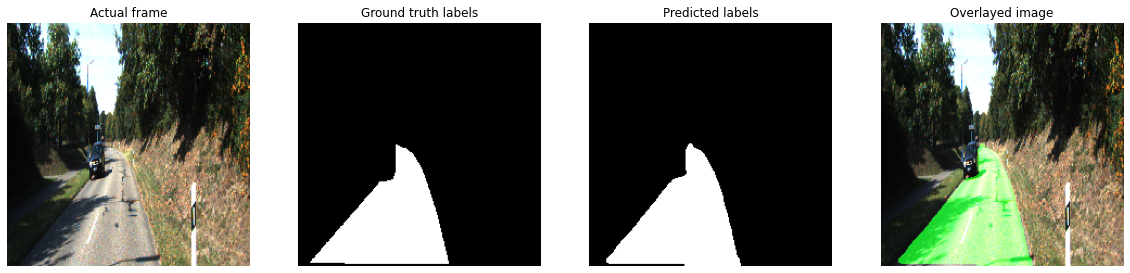

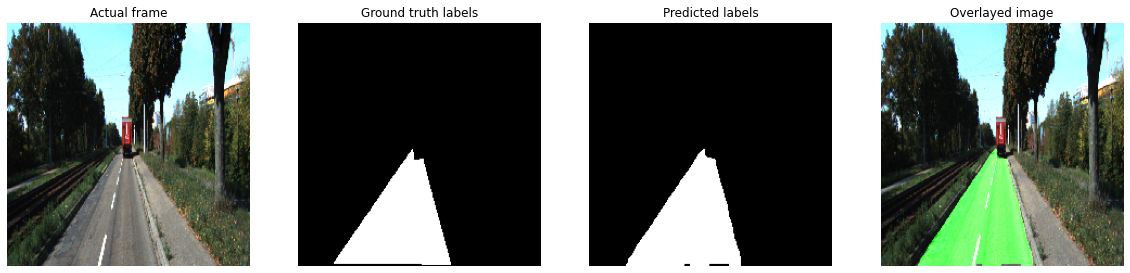

1/1 [==============================] - 0s 31ms/step


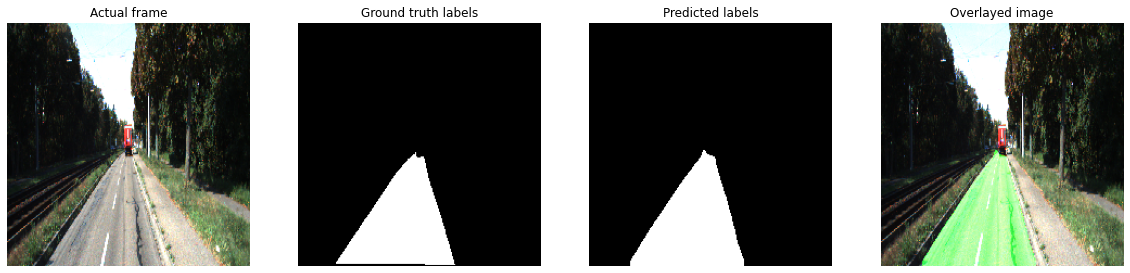

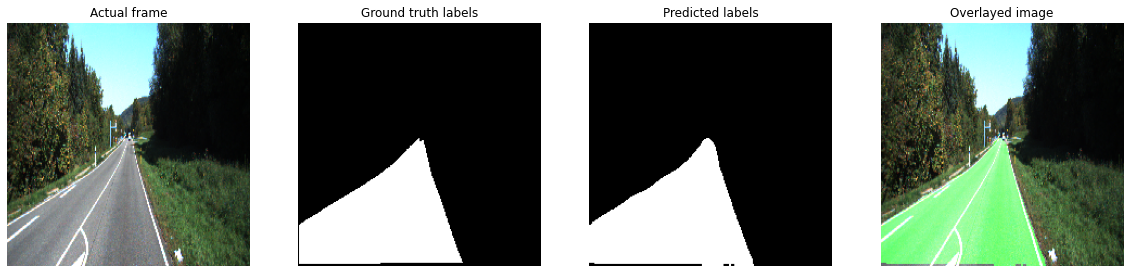

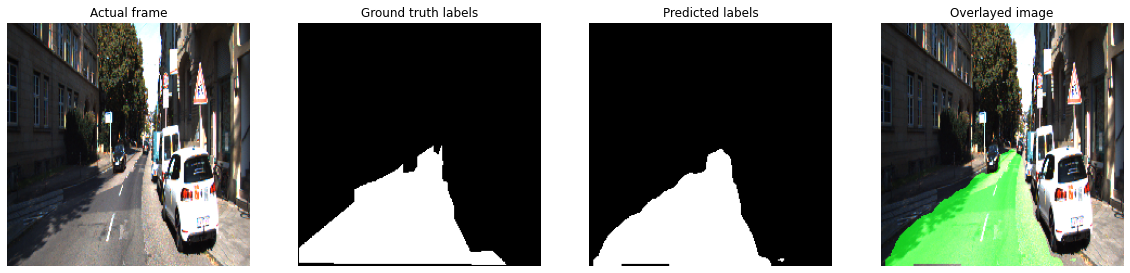

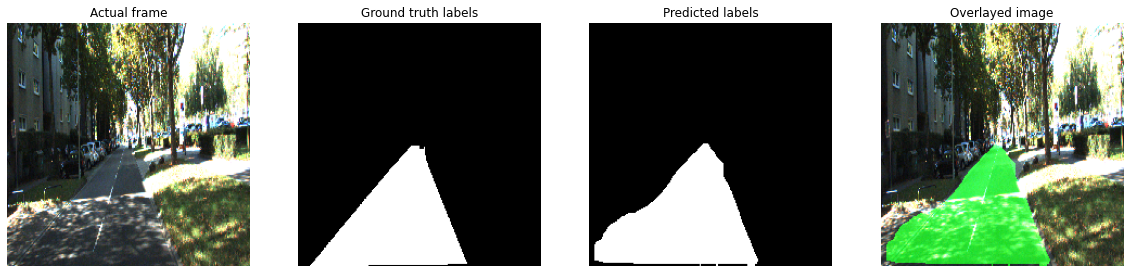

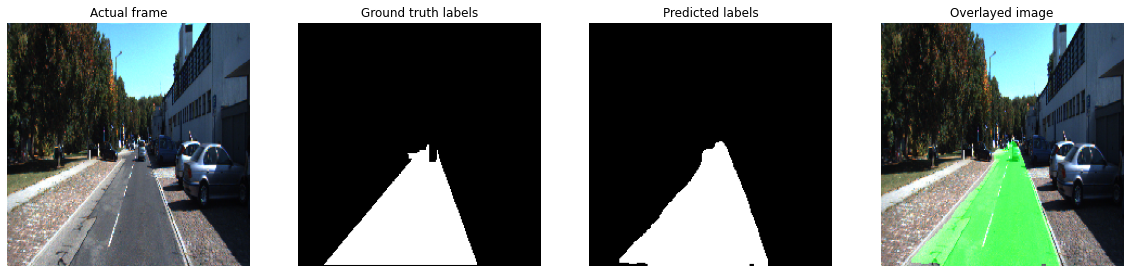

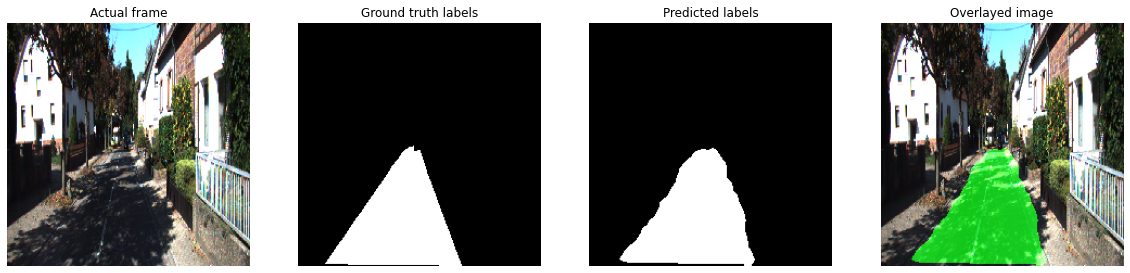

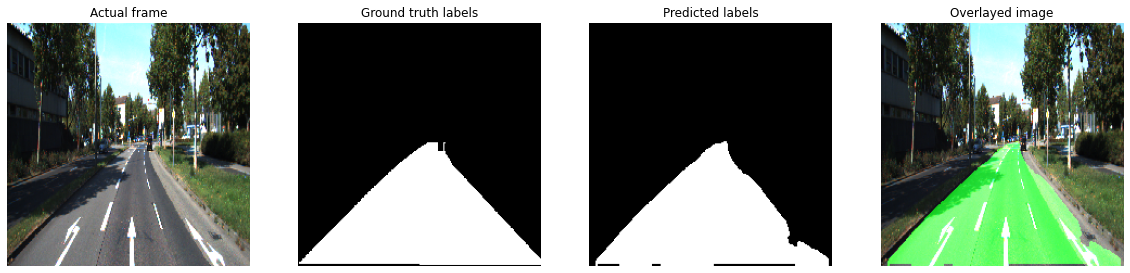

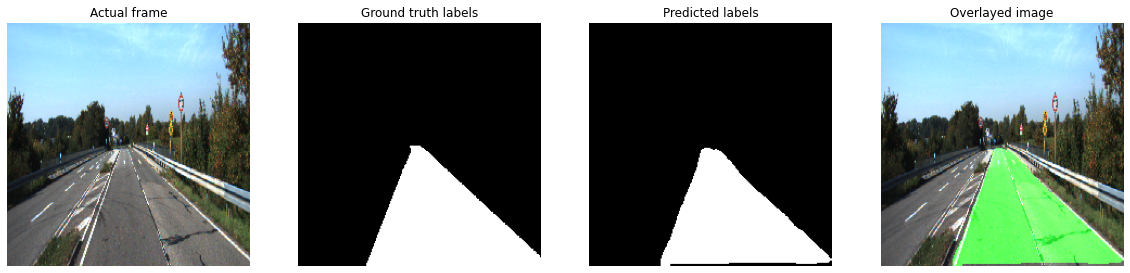

1/1 [==============================] - 0s 26ms/step


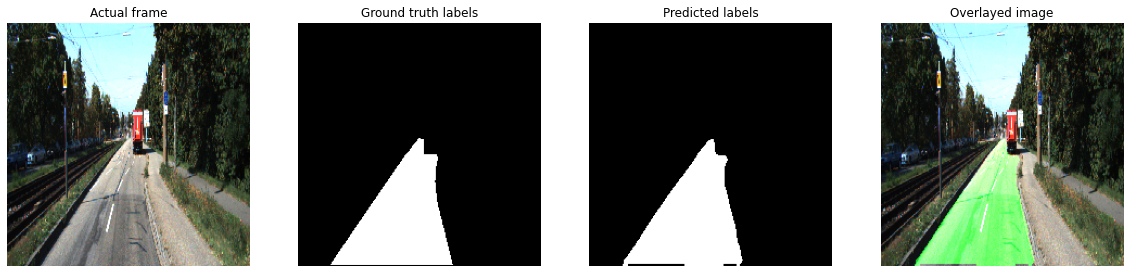

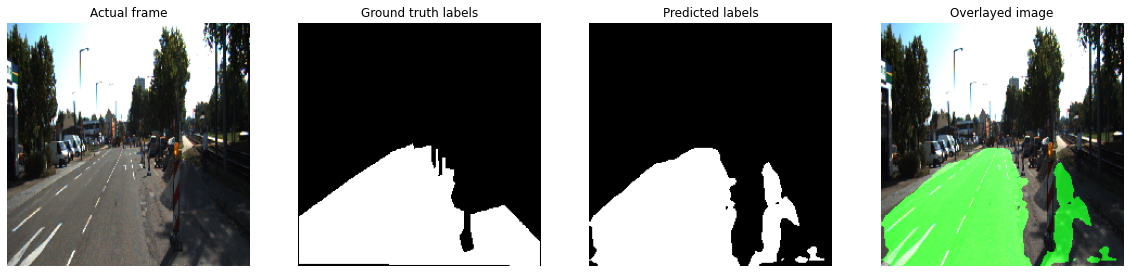

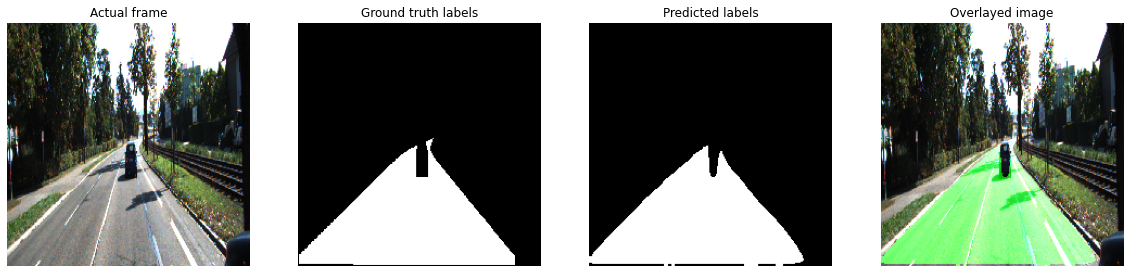

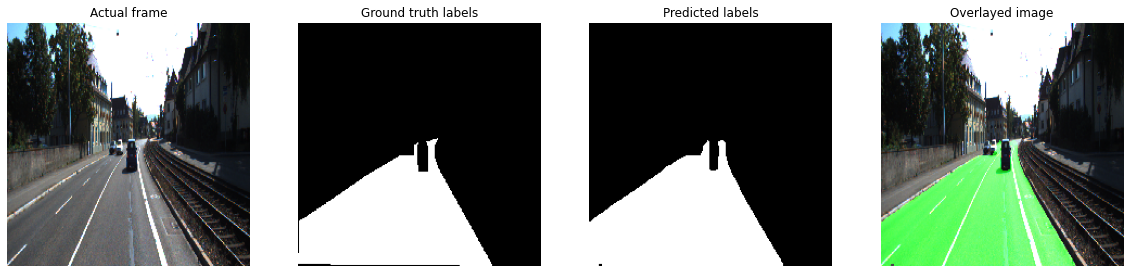

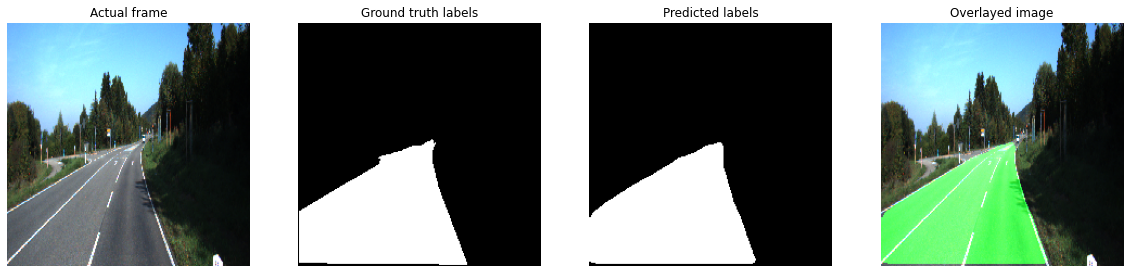

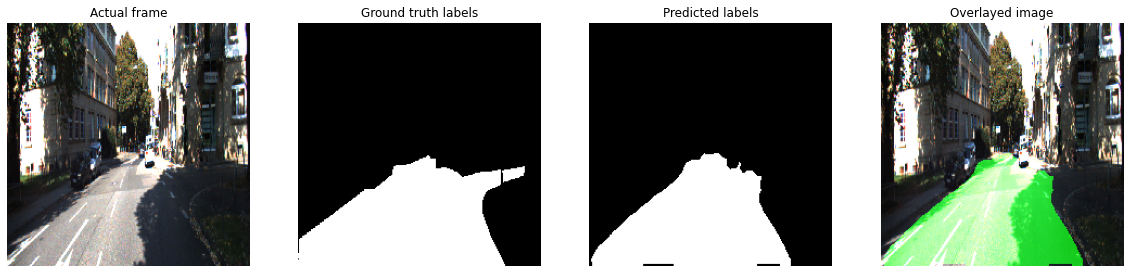

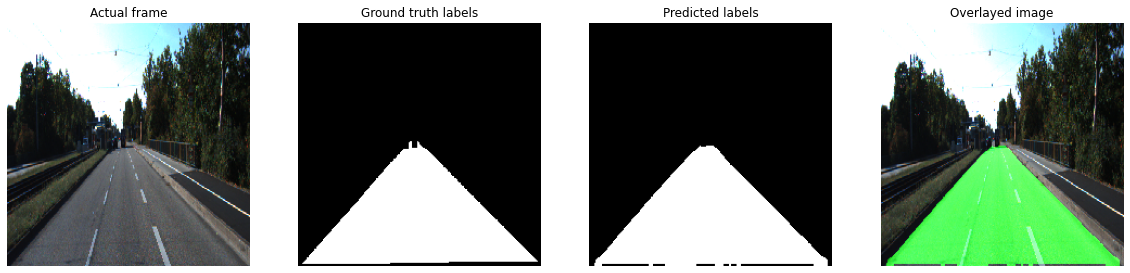

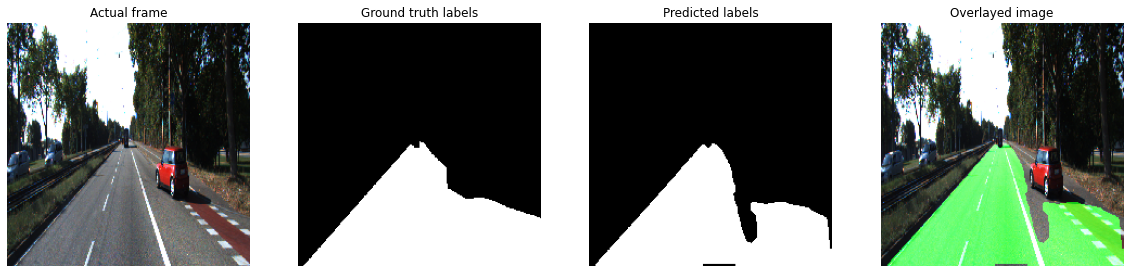

1/1 [==============================] - 0s 26ms/step


In [ ]:
inference(trained_model, valid_ds)